# Recommender system

### How to recommend?

suppose: User u1 gave Rick and Morty a 4, Bojack Horseman got a 4, and Wolfwalkers got a 4.
User u1 is most likely a lover of Animation and Adventure.

---

***Given a dataset of triples: (user, item, rating) Fit a model to the data: function(user, item) → rating.***

---

**What should it do?**

 If the user u1 and the movie m1 were in the dataset, the projected rating should be close to the true rating.
Even if movie m1 did not appear in the training set, the function should predict what user u1 would rank it.

Since our model can predict ratings for unseen movies, this is easy. Given a user, get predicted for every unseen movie, Sort by predicted rating (descending), Recommend movies with the highest predicted rating.


Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

## ::::: Section 1 Importing data :::::

### -x- Downloading dataset in colab. -x-

In [2]:
# data is from: https://grouplens.org/datasets/movielens/
# in case the link changes in the future

!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2021-05-21 13:34:41--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  71.1MB/s    in 2.7s    

2021-05-21 13:34:44 (71.1 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



### -x- Listing files in colab -x-

In [3]:
!ls

ml-20m.zip  sample_data


### -x- Unzipping the downloaded file -x-

In [4]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


### -x- Removing zip file after it is extracted -x- 

In [5]:
!rm ml-20m.zip

### -x- Listing files in colab again -x-

In [6]:
!ls

ml-20m	sample_data


In [7]:
!ls ml-20m

genome-scores.csv  links.csv   ratings.csv  tags.csv
genome-tags.csv    movies.csv  README.txt


### -x- Creating dataframe -x-

In [8]:
dataframe = pd.read_csv('ml-20m/ratings.csv')
dataframe.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


As you can see in the above cell, one user may have seen and rated one or more films.

### -x- Casting userId column into categorical data. -x-

In [9]:
# Pandas categoricals are a new and powerful feature that encodes categorical data numerically.

dataframe.userId = pd.Categorical(dataframe.userId)
dataframe['new_user_id'] = dataframe.userId.cat.codes

### -x- Casting movieId column into categorical data. -x-

In [10]:
# Now do the same thing for movie ids

dataframe.movieId = pd.Categorical(dataframe.movieId)
dataframe['new_movie_id'] = dataframe.movieId.cat.codes

### -x- Getting user IDs, movie IDs, and ratings as separate arrays. -x-

In [11]:
user_ids = dataframe['new_user_id'].values
movie_ids = dataframe['new_movie_id'].values
ratings = dataframe['rating'].values

### -x- Getting number of users and number of movies. -x-

In [12]:
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
K = 10

## ::::: Section 2 NN :::::

### -x- Training the model -x-

In [13]:
# User input
u = tf.keras.layers.Input(shape=(1,)) # cos userId is single integer

# Movie input
m = tf.keras.layers.Input(shape=(1,)) # cos movieId is single integer

# User embedding
u_emb = tf.keras.layers.Embedding(N, K)(u) # output is (num_samples, 1, K)

# Movie embedding
m_emb = tf.keras.layers.Embedding(M, K)(m) # output is (num_samples, 1, K)

# Flatten both embeddings
u_emb = tf.keras.layers.Flatten()(u_emb) # now it's (num_samples, K)
m_emb = tf.keras.layers.Flatten()(m_emb) # now it's (num_samples, K)

# Concatenate user-movie embeddings into a feature vector
x = tf.keras.layers.Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a regular ANN
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(inputs=[u, m], outputs=x)

### -x- Compiling the model -x-

In [14]:
model.compile(
  loss='mse',
  optimizer=tf.keras.optimizers.SGD(lr=0.08, momentum=0.9),
)

### -x- splitting the data into train and test sets -x-

In [15]:
from sklearn.utils import shuffle

user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

### -x- Fitting the data on model -x-

In [16]:
history = model.fit(
  x=[train_user, train_movie],
  y=train_ratings,
  epochs=25,
  batch_size=1024,
  verbose=2, # goes a little faster when you don't print the progress bar
  validation_data=([test_user, test_movie], test_ratings),
)

Epoch 1/25
15626/15626 - 158s - loss: 0.7766 - val_loss: 0.7251
Epoch 2/25
15626/15626 - 165s - loss: 0.7008 - val_loss: 0.7006
Epoch 3/25
15626/15626 - 165s - loss: 0.6778 - val_loss: 0.6831
Epoch 4/25
15626/15626 - 167s - loss: 0.6631 - val_loss: 0.6758
Epoch 5/25
15626/15626 - 170s - loss: 0.6532 - val_loss: 0.6716
Epoch 6/25
15626/15626 - 172s - loss: 0.6404 - val_loss: 0.6627
Epoch 7/25
15626/15626 - 174s - loss: 0.6227 - val_loss: 0.6480
Epoch 8/25
15626/15626 - 176s - loss: 0.6101 - val_loss: 0.6474
Epoch 9/25
15626/15626 - 182s - loss: 0.6011 - val_loss: 0.6408
Epoch 10/25
15626/15626 - 187s - loss: 0.5933 - val_loss: 0.6386
Epoch 11/25
15626/15626 - 208s - loss: 0.5862 - val_loss: 0.6349
Epoch 12/25
15626/15626 - 186s - loss: 0.5789 - val_loss: 0.6362
Epoch 13/25
15626/15626 - 191s - loss: 0.5718 - val_loss: 0.6296
Epoch 14/25
15626/15626 - 185s - loss: 0.5655 - val_loss: 0.6287
Epoch 15/25
15626/15626 - 179s - loss: 0.5598 - val_loss: 0.6276
Epoch 16/25
15626/15626 - 181s - l

### -x- Plotting loss per iteration -x-


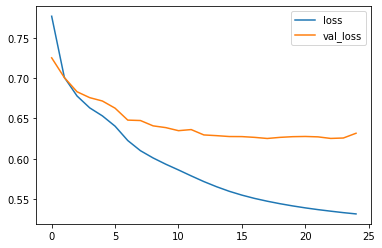

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### -x- Is this on par with other approaches? -x-

In [18]:
# https://datascience.stackexchange.com/questions/29740/benchmark-result-for-movielens-dataset
np.sqrt(0.6259)

0.7911384202527394